<a href="https://colab.research.google.com/github/lutherkhill/codemash2020/blob/master/codemash.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **A Civic Developers Quest to Change Healthcare**


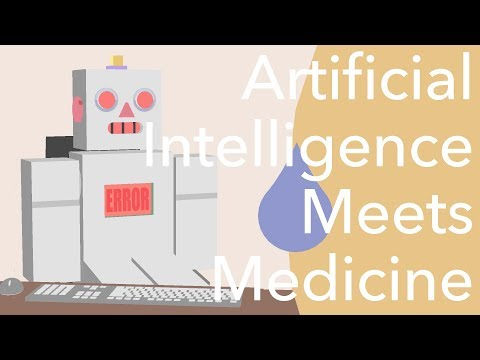

In [0]:
from IPython.display import YouTubeVideo
YouTubeVideo('ZIiYbMVs7-8')

##Description and problem statement

For this application we used PyTorch and FastAi libary to design our model. We got our data from Kaggle using the Chest X-ray datset from the National Insitutue of Health (NIH). We used Jupyter notebooks that was hosted in the cloud using Google Colab to build and deploy our model. the Google Colab infrastructure allows us to leverage free resources like Graphical Processing Units (GPU) and SSD hard drives. 

To train our 

##Goals for talk

We will build and deploy a model tht meets the current state of the art for chest x-ray disease prediction using the AUC-ROC socring metric.

# **The dataset**

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# load fastai dependencies
import fastai
from fastai.vision import *
from fastai.metrics import *

# Imports for diverse utilities
import torchvision.models as models
from tqdm import tqdm
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern
from sklearn.metrics import roc_auc_score, recall_score

#conect to google drive to easier storeage and redundency
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [2]:
os.chdir("/gdrive/My Drive/heart_disease/sample")
os.getcwd()

'/gdrive/My Drive/heart_disease/sample'

In [0]:
from IPython.display import IFrame
IFrame('https://blog.revolutionanalytics.com/2016/11/calculating-auc.html',
       width='100%', height=500)

## Get the data
The NIH dataset is freely availble on kaggle. For this exercise we will be using a smaple set o the data. Let's see how to do this by using the Kaggle API as it's going to be pretty useful to you if you want to join a competition or use other Kaggle datasets later on.

First, install the Kaggle API by uncommenting the following line and executing it, or by executing it in your terminal (depending on your platform you may need to modify this slightly to either add source activate fastai or similar, or prefix pip with a path. Have a look at how conda install is called for your platform in the appropriate Returning to work section of https://course.fast.ai/. (Depending on your environment, you may also need to append "--user" to the command.)

In [0]:
# install the kaggle command line tool
# ! {sys.executable} -m pip install kaggle --upgrade

You're all set to download the data from planet competition. You first need to go to its main page and accept its rules, and run the two cells below (uncomment the shell commands to download and unzip the data). If you get a 403 forbidden error it means you haven't accepted the competition rules yet (you have to go to the competition page, click on Rules tab, and then scroll to the bottom to find the accept button).

In [0]:
# this will download the dataset right into your gdrive and unzip the file
# !kaggle datasets download -d nih-chest-xrays/sample
# !unzip -q sample.zip

### Load data

In [5]:
# set path to data
path = "/gdrive/My Drive/heart_disease/sample/images/"

#number of images
img_files = os.listdir(path)
img_files[:5], len(img_files)

(['00027168_001.png',
  '00027236_000.png',
  '00027110_000.png',
  '00027213_086.png',
  '00027089_001.png'],
 5611)

### Explore Data

In [0]:
# load help packages
import pandas as pd

import matplotlib.pyplot as plt # basic plotting
import seaborn as sns # additional plotting functionality

In [7]:
#load data into data drame for exploration
xray_data = pd.read_csv('/gdrive/My Drive/heart_disease/sample/images/labels.csv')

#see how many observations there are
num_obs = len(xray_data)
print('Number of obervations: ',num_obs)

Number of obervations:  5606


Number of unique labels: 244
                                                    Finding Labels
No Finding                                                    3044
Infiltration                                                   503
Effusion                                                       203
Atelectasis                                                    192
Nodule                                                         144
...                                                            ...
Atelectasis|Emphysema|Infiltration|Mass|Pneumot...               1
Consolidation|Effusion|Pneumothorax                              1
Emphysema|Infiltration|Pleural_Thickening|Pneum...               1
Infiltration|Mass|Nodule|Pneumothorax                            1
Atelectasis|Consolidation|Effusion|Emphysema                     1

[244 rows x 1 columns]


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2bc2c10dd8>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
  <a list of 20 Text xticklabel objects>))

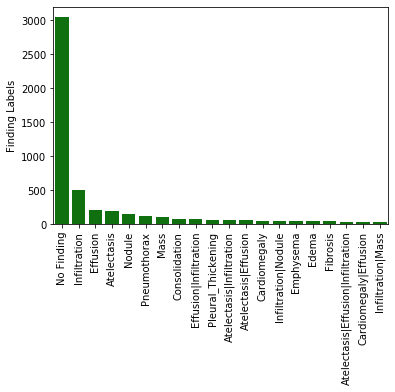

In [17]:
# Explore the dataset a bit

# Q: how many unique labels are there? A: many (836) because of co-occurence
# Note: co-occurence will turn out to be a real pain to deal with later, but there are several techniques that help us work with it successfully
num_unique_labels = xray_data['Finding Labels'].nunique()
print('Number of unique labels:',num_unique_labels)

# let's look at the label distribution to better plan our next step
count_per_unique_label = xray_data['Finding Labels'].value_counts() # get frequency counts per label
df_count_per_unique_label = count_per_unique_label.to_frame() # convert series to dataframe for plotting purposes

print(df_count_per_unique_label) # view tabular results
sns.barplot(x = df_count_per_unique_label.index[:20], y="Finding Labels", data=df_count_per_unique_label[:20], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [18]:
# define dummy labels for one hot encoding - simplifying to 14 primary classes (excl. No Finding)
dummy_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening', 
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'] # taken from paper

# One Hot Encoding of Finding Labels to dummy_labels
for label in dummy_labels:
    xray_data[label] = xray_data['Finding Labels'].map(lambda result: 1.0 if label in result else 0)
xray_data.head(20) # check the data, looking good!

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,0.139000,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,0.168000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,0.168000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,0.143000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,0.168000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5,00000040_003.png,Consolidation|Mass,3,40,068Y,M,PA,2500,2048,0.168000,0.168000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,00000042_002.png,No Finding,2,42,071Y,M,AP,3056,2544,0.139000,0.139000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,00000057_001.png,No Finding,1,57,071Y,M,AP,3056,2544,0.139000,0.139000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,00000061_002.png,Effusion,2,61,077Y,M,PA,2992,2991,0.143000,0.143000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,00000061_019.png,No Finding,19,61,077Y,M,AP,3056,2544,0.139000,0.139000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Infiltration          967.0
Effusion              644.0
Atelectasis           508.0
Nodule                313.0
Mass                  284.0
Pneumothorax          271.0
Consolidation         226.0
Pleural_Thickening    176.0
Cardiomegaly          141.0
Emphysema             127.0
Edema                 118.0
Fibrosis               84.0
Pneumonia              62.0
Hernia                 13.0
dtype: float64


(<matplotlib.axes._subplots.AxesSubplot at 0x7f2bc2c4e2e8>,
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
  <a list of 14 Text xticklabel objects>))

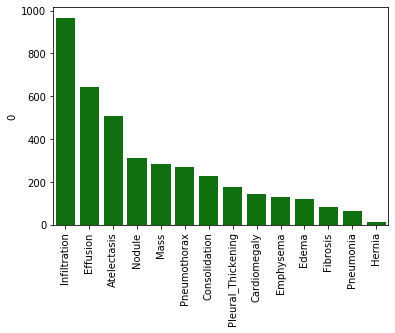

In [19]:
# now, let's see how many cases present for each of of our 14 clean classes (which excl. 'No Finding')
clean_labels = xray_data[dummy_labels].sum().sort_values(ascending= False) # get sorted value_count for clean labels
print(clean_labels) # view tabular results

# plot cases using seaborn barchart
clean_labels_df = clean_labels.to_frame() # convert to dataframe for plotting purposes
sns.barplot(x = clean_labels_df.index[::], y= 0, data = clean_labels_df[::], color = "green"), plt.xticks(rotation = 90) # visualize results graphically

In [20]:
## MODEL CREATION PHASE STARTS HERE

# create vector as ground-truth, will use as actuals to compare against our predictions later
xray_data['target_vector'] = xray_data.apply(lambda target: [target[dummy_labels].values], 1).map(lambda target: target[0])
xray_data.head() # take a look to ensure target_vector makes sense

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia,target_vector
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."


1. Delete the following labels

- delete hernia- not cinically relevant

- delete pneumothorax- not clinically relevant becaue case already had tubes and were treated

- delete Pneumonia, emphysema, and most of fibrosis : these are diagnosed clnically not based on imaging

2. keep the following 5 labels that are relevant

- atelectasis, cardiomegaly, consolidation, edema, pleural effusion





### Create Databunch

In [0]:
# construct the the data source
np.random.seed(42)
src = (ImageList.from_csv(path, 'labels.csv', convert_mode='L').split_by_rand_pct(0.2).label_from_df(label_delim='|', cols="Finding Labels"))

In [0]:
# sets the transformation for the dat to crop out unused parts of the image
#tfms = zoom_crop(scale=(0.50,1), do_rand=False, p=1)
tfms = get_transforms(do_flip=True, 
                      flip_vert=False, 
                      max_rotate=5,
                      max_zoom=1.03,
                      max_lighting=0.03,
                      max_warp=0.03,
                      p_affine=0.05,
                      p_lighting=0.05,
                      )

In [0]:
#construct data bunch (need to add weight decay and drop out rate to improve accuracy)
data = (src.transform(size=256).databunch(bs=36).normalize(imagenet_stats))

In [13]:
# list the names of you data classes
data.classes

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [12]:
# data bunch information
data

ImageDataBunch;

Train: LabelList (4485 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: MultiCategoryList
Emphysema;Infiltration;Pleural_Thickening;Pneumothorax,Cardiomegaly;Emphysema,No Finding,Atelectasis,Cardiomegaly;Edema;Effusion
Path: /gdrive/My Drive/heart_disease/sample/images;

Valid: LabelList (1121 items)
x: ImageList
Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256),Image (1, 256, 256)
y: MultiCategoryList
No Finding,No Finding,Mass;Nodule,No Finding,Consolidation;Mass
Path: /gdrive/My Drive/heart_disease/sample/images;

Test: None

In [0]:
# show the number of classes that your data has
data.c

4

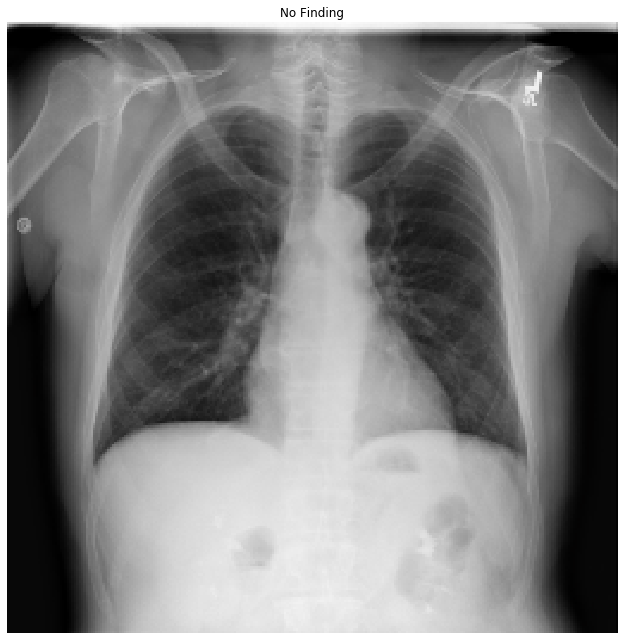

In [14]:
#display data bunch
# size/quality of the image matters greatly from medical imaging analysis
data.show_batch(rows=1, figsize=(12,9))

#**The model**
Our base architecture is `resnet50` again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of accuracy. We determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

> Indented block



### Single Model

In [0]:
def auroc_score(input_, target):
    input_, target = input_.cpu().numpy(), target.cpu().numpy() #.reshape(-1, learn.data.c)
    score = []
    for i in range(14):
        try: 
            score.append(roc_auc_score(target[:,i], input_[:,i]))
        except ValueError:
            score.append(0)
    
    return np.array(score).mean()

#     def __init__(self):
#         pass

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_metrics, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            metric = auroc_score(output, target)
            return add_metrics(last_metrics, metric)

In [0]:
# create convolutional neural network and return the accuracy metric
ResNet = cnn_learner(data, models.resnet50, metrics=[fbeta, AUROC()]).to_fp32()
#GoogleNet = cnn_learner(data, models.googlenet, metrics=[AUROC(), fbeta]).to_fp16()

In [0]:
ResNet.summary()

In [0]:
ResNet.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


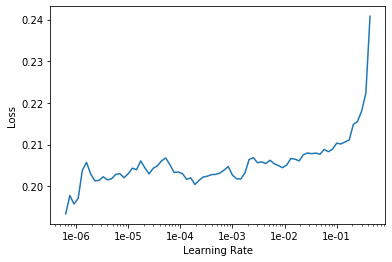

In [34]:
 # find the ideal inital learning rate for your model
ResNet.lr_find()
ResNet.recorder.plot()

In [33]:
# to pic the ideal learning rate we find the stepest part of the curve and back it up by a factor of ten.
ResNet.fit_one_cycle(10, slice(1e-03, 1e-01))

epoch,train_loss,valid_loss,fbeta,auroc,time
0,0.304282,1.415482,0.499016,0.551681,01:04
1,0.280633,0.228417,0.573284,0.574318,01:02
2,0.306349,2.698753,0.419207,0.518089,01:02
3,0.341068,0.265565,0.518287,0.506392,01:02
4,0.274433,1.592446,0.557144,0.541460,01:02
5,0.246142,2.007023,0.566962,0.575253,01:02
6,0.229948,0.221772,0.567182,0.571611,01:02
7,0.218030,1.476611,0.572625,0.600133,01:04
8,0.213003,2.252389,0.581570,0.622947,01:03
9,0.206223,5.048634,0.578390,0.628402,01:03


In [0]:
# save the initial model
ResNet.save('codemash-WideResNet-16bit')

In [0]:
ResNet.export('codemash-WideResNet-16bit')

In [0]:
ResNet.export()

Object `export` not found.


## Metrics

In [45]:
# we will start taking a look a the metrics
ResNet.plot_metrics()

AttributeError: ignored

In [36]:
#Look at your 9 worst results. By using a heatmap to see what induced the wrong classification:
interp = ClassificationInterpretation.from_learner(ResNet)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

False

524 misclassified samples over 1121 samples in the validation set.


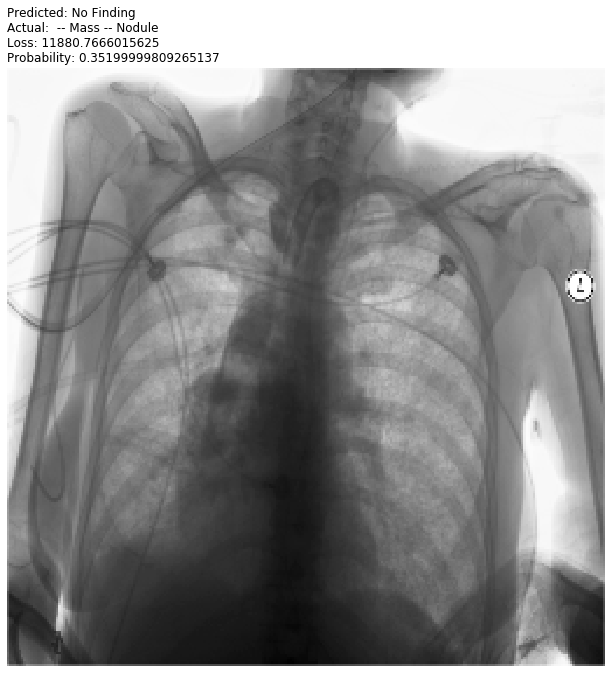

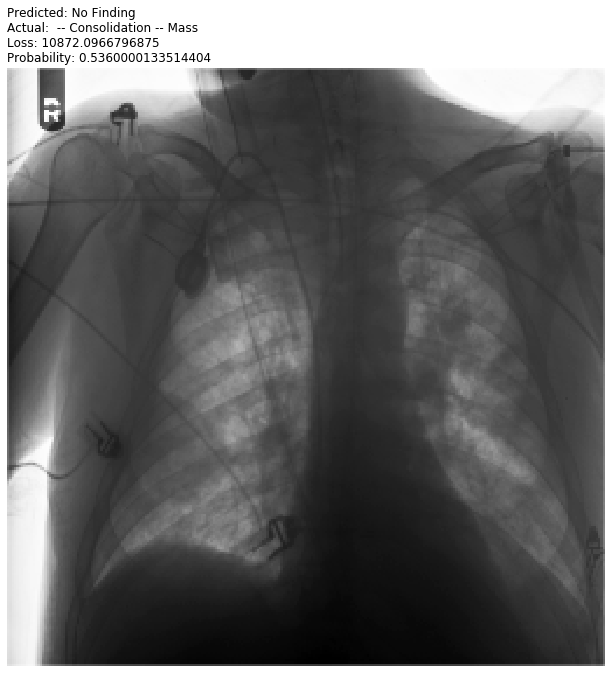

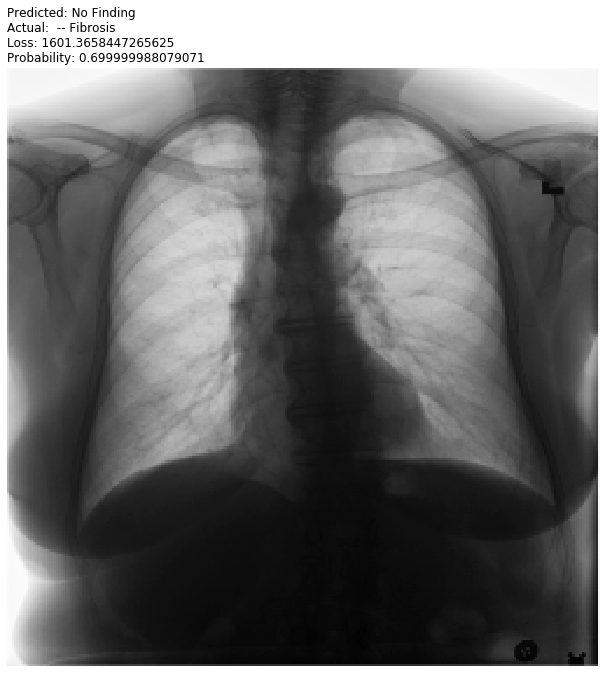

In [37]:
#plot top losses
interp.plot_multi_top_losses(3, figsize=(20,11))

In [40]:
interp.most_confused(min_val=100)

[('Atelectasis', 'No Finding', 14480),
 ('Cardiomegaly', 'No Finding', 1300),
 ('Atelectasis', 'Infiltration', 729),
 ('Atelectasis', 'Effusion', 140)]

In [0]:
pred_class, pred_idx, outputs = ResNet.predict(open_image(f"{path}/00001989_001.png"))

In [43]:
[f'{round(y.item()*100):3d}% - {c}' for c,y in zip(data.classes, outputs) if y > 0.50]

[' 58% - No Finding']

In [0]:
#unfreeze previous model to continue improving the model
learn.unfreeze()

In [0]:
# EXPORT MODEL
learner.export('codemash-resnet50-16bit'')

## Test the Finished Model

In [0]:
learn = load_learner(path, 'codemash-WideResNet-16bit.pkl')

In [0]:
test_data = learn.data.train_ds[0][0]

In [0]:
pred_class, pred_idx, outputs = learn.predict(open_image(f"{path}00001989_001.png"))

In [0]:
[f'{round(y.item()*100):3d}% - {c}' for c,y in zip(data.classes, outputs) if y > 0.75]

[' 77% - Lung_anomalies']

## Diagnosing and fixing problems

I added this section because of the GPU memory management issues i kept running into with working with the notebook. The basic problems comes from limited memory capicity in most cloud services. Periodically you will have to free up memory to keep the training process going. this section will help you identify memory bottle necks and fix them.

In [0]:
# use to identify gpu mem usage
!/opt/bin/nvidia-smi
!nvcc --version

#identify processes using gpu memory
print("\nKill process with 'ipykernel_launcher'\n")
!ps -aux|grep python

Sat Dec  7 22:38:36 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    31W / 250W |  16273MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# kill process with "ipkernel_launcher" to free gpu memory
!kill -9 148

# **Deploy model on webapp**

- www.render.com
- www.github.com
